In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

2024-04-08 12:22:15.383987: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 12:22:15.417284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 12:22:15.417303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 12:22:15.418129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 12:22:15.423581: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


## Example Pinball loss / Quantile loss

In [3]:
tau=0.1
y_hat=3
y=np.linspace(y_hat-10,y_hat+10,100)

# Calculate loss
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat
loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [4]:
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat

loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [5]:
tau=0.1
y_hat=3
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]

def plot_function(tau):
    
    loss=(1-tau)*(np.abs(u))
    y_larger=u<0
    loss[y_larger]=tau*(np.abs(u[y_larger]))

    plt.plot(u,loss)
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.grid()
    plt.xticks(u_ticks)
    plt.xlim([-10,10])
    plt.ylim([-1,8])
    plt.legend([r'$\mathcal{L}(y_{\tau},y)$',r'$y_{\tau}$'])
    plt.xlabel(r"$u=y_{\tau}-y$")
    plt.ylabel(r'$\mathcal{L}$')
    plt.title(r'Example of the Quantile loss / Pinball loss function')
    plt.show()
    
interact(plot_function, tau = widgets.FloatSlider(value=0.1,
                                               min=0.0,
                                               max=1.0,
                                               step=0.01))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_function(tau)>

## Plot for report

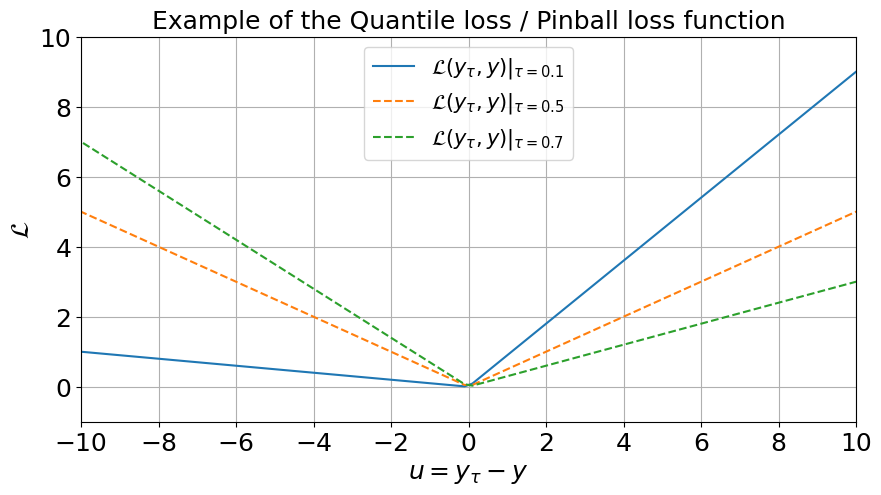

In [23]:
tau=0.1
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]    

loss=(1-tau)*(np.abs(u))
y_larger=u<0
loss[y_larger]=tau*(np.abs(u[y_larger]))

tau_2=0.5
loss_2=(1-tau_2)*(np.abs(u))
loss_2[y_larger]=tau_2*(np.abs(u[y_larger]))

tau_3=0.7
loss_3=(1-tau_3)*(np.abs(u))
loss_3[y_larger]=tau_3*(np.abs(u[y_larger]))

fontsize=18

plt.plot(u,loss)
plt.plot(u,loss_2,'--')
plt.plot(u,loss_3,'--')
plt.rcParams["figure.figsize"] = [10, 5]
plt.grid()
plt.xticks(u_ticks,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([-10,10])
plt.ylim([-1,10])
plt.legend([r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.1}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.5}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.7}$'],fontsize=fontsize-3)
plt.xlabel(r"$u=y_{\tau}-y$",fontsize=fontsize)
plt.ylabel(r'$\mathcal{L}$',fontsize=fontsize)
plt.title(r'Example of the Quantile loss / Pinball loss function',fontsize=fontsize)
plt.show()

## Example Quantile Regression Neural Networks (QRNN)

In [7]:
def draw_sample_sin(n_samps, sigma):
    x=np.random.uniform(low=0,high=2*np.pi,size=n_samps)
    noise=np.random.normal(loc=0,scale=sigma,size=n_samps)
    y=np.sin(x)+noise
    return x,y

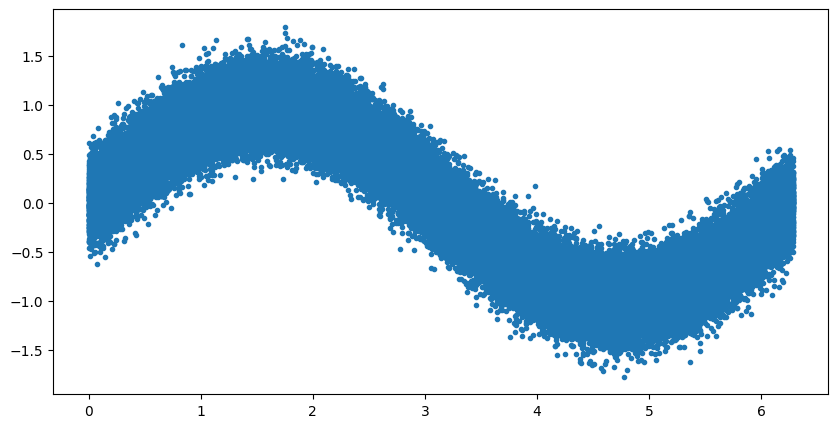

In [8]:
x,y = draw_sample_sin(100000,0.2)
plt.plot(x,y,'.')

In [9]:
x=np.array([x]).T
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.05)


import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train)), int(len(X_train)*val_size)))
train_indices=[i for i in range(len(X_train)) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500


In [10]:
nepochs=200
quantiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(1,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*1) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train,y_train, 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Batch number: 100%|██████████| 181/181 [00:00<00:00, 355.92it/s]

Training loss [1.9569404] Validation loss [1.1675019]
----New best validation loss---- [1.1675019]
Epoch 2



Batch number: 100%|██████████| 181/181 [00:00<00:00, 584.46it/s]

Training loss [1.0841429] Validation loss [0.9829532]
----New best validation loss---- [0.9829532]
Epoch 3



Batch number: 100%|██████████| 181/181 [00:00<00:00, 560.96it/s]

Training loss [0.928559] Validation loss [0.8634558]
----New best validation loss---- [0.8634558]
Epoch 4



Batch number: 100%|██████████| 181/181 [00:00<00:00, 565.59it/s]

Training loss [0.82179683] Validation loss [0.7722534]
----New best validation loss---- [0.7722534]
Epoch 5



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.85it/s]

Training loss [0.73976827] Validation loss [0.70567924]
----New best validation loss---- [0.70567924]
Epoch 6



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.13it/s]

Training loss [0.67209786] Validation loss [0.6468993]
----New best validation loss---- [0.6468993]
Epoch 7



Batch number: 100%|██████████| 181/181 [00:00<00:00, 589.12it/s]

Training loss [0.6256699] Validation loss [0.61811924]
----New best validation loss---- [0.61811924]
Epoch 8



Batch number: 100%|██████████| 181/181 [00:00<00:00, 585.37it/s]

Training loss [0.6032381] Validation loss [0.601683]
----New best validation loss---- [0.601683]
Epoch 9



Batch number: 100%|██████████| 181/181 [00:00<00:00, 401.60it/s]

Training loss [0.5906169] Validation loss [0.591136]
----New best validation loss---- [0.591136]
Epoch 10



Batch number: 100%|██████████| 181/181 [00:00<00:00, 607.28it/s]


Training loss [0.5840498] Validation loss [0.5891372]
----New best validation loss---- [0.5891372]
Epoch 11


Batch number: 100%|██████████| 181/181 [00:00<00:00, 599.15it/s]

Training loss [0.57932675] Validation loss [0.5919053]
Epoch 12



Batch number: 100%|██████████| 181/181 [00:00<00:00, 604.20it/s]


Training loss [0.57780254] Validation loss [0.5853373]
----New best validation loss---- [0.5853373]
Epoch 13


Batch number: 100%|██████████| 181/181 [00:00<00:00, 590.41it/s]

Training loss [0.57667744] Validation loss [0.5780068]
----New best validation loss---- [0.5780068]
Epoch 14



Batch number: 100%|██████████| 181/181 [00:00<00:00, 565.88it/s]

Training loss [0.5748519] Validation loss [0.58003813]
Epoch 15



Batch number: 100%|██████████| 181/181 [00:00<00:00, 563.01it/s]

Training loss [0.575165] Validation loss [0.58101106]
Epoch 16



Batch number: 100%|██████████| 181/181 [00:00<00:00, 592.83it/s]

Training loss [0.5741231] Validation loss [0.57589424]
----New best validation loss---- [0.57589424]
Epoch 17



Batch number: 100%|██████████| 181/181 [00:00<00:00, 585.67it/s]

Training loss [0.5729687] Validation loss [0.58041734]
Epoch 18



Batch number: 100%|██████████| 181/181 [00:00<00:00, 596.31it/s]

Training loss [0.57298416] Validation loss [0.5783161]
Epoch 19



Batch number: 100%|██████████| 181/181 [00:00<00:00, 603.25it/s]


Training loss [0.57248175] Validation loss [0.5817374]
Epoch 20


Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.80it/s]

Training loss [0.5718137] Validation loss [0.57729816]
Epoch 21



Batch number: 100%|██████████| 181/181 [00:00<00:00, 595.04it/s]

Training loss [0.57214195] Validation loss [0.5809019]
Epoch 22



Batch number: 100%|██████████| 181/181 [00:00<00:00, 562.71it/s]

Training loss [0.57211196] Validation loss [0.57698905]
Epoch 23



Batch number: 100%|██████████| 181/181 [00:00<00:00, 605.41it/s]


Training loss [0.5718462] Validation loss [0.5795898]
Epoch 24


Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.87it/s]


Training loss [0.5714084] Validation loss [0.5852135]
Epoch 25


Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.60it/s]

Training loss [0.5718038] Validation loss [0.5781958]
Epoch 26



Batch number: 100%|██████████| 181/181 [00:00<00:00, 564.27it/s]

Training loss [0.57190686] Validation loss [0.5784328]
Epoch 27



Batch number: 100%|██████████| 181/181 [00:00<00:00, 565.60it/s]

Training loss [0.57179177] Validation loss [0.5779032]
Epoch 28



Batch number: 100%|██████████| 181/181 [00:00<00:00, 559.25it/s]

Training loss [0.57046956] Validation loss [0.57426304]
----New best validation loss---- [0.57426304]
Epoch 29



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.88it/s]

Training loss [0.57036144] Validation loss [0.5835206]
Epoch 30



Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.35it/s]

Training loss [0.5703989] Validation loss [0.5787621]
Epoch 31



Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.75it/s]

Training loss [0.5691911] Validation loss [0.5774977]
Epoch 32



Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.35it/s]

Training loss [0.57041794] Validation loss [0.5749822]
Epoch 33



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.10it/s]

Training loss [0.56935436] Validation loss [0.5743545]
Epoch 34



Batch number: 100%|██████████| 181/181 [00:00<00:00, 607.32it/s]


Training loss [0.5707981] Validation loss [0.57780915]
Epoch 35


Batch number: 100%|██████████| 181/181 [00:00<00:00, 630.61it/s]

Training loss [0.57150805] Validation loss [0.57449645]
Epoch 36



Batch number: 100%|██████████| 181/181 [00:00<00:00, 610.07it/s]


Training loss [0.5698062] Validation loss [0.5734765]
----New best validation loss---- [0.5734765]
Epoch 37


Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.84it/s]

Training loss [0.56862575] Validation loss [0.5799192]
Epoch 38



Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.08it/s]

Training loss [0.5696279] Validation loss [0.57346433]
----New best validation loss---- [0.57346433]
Epoch 39



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.70it/s]

Training loss [0.5696545] Validation loss [0.57389116]
Epoch 40



Batch number: 100%|██████████| 181/181 [00:00<00:00, 602.42it/s]


Training loss [0.5698167] Validation loss [0.5730216]
----New best validation loss---- [0.5730216]
Epoch 41


Batch number: 100%|██████████| 181/181 [00:00<00:00, 588.55it/s]

Training loss [0.56890297] Validation loss [0.5770838]
Epoch 42



Batch number: 100%|██████████| 181/181 [00:00<00:00, 586.48it/s]

Training loss [0.56897813] Validation loss [0.5717403]
----New best validation loss---- [0.5717403]
Epoch 43



Batch number: 100%|██████████| 181/181 [00:00<00:00, 593.87it/s]

Training loss [0.5689728] Validation loss [0.5754571]
Epoch 44



Batch number: 100%|██████████| 181/181 [00:00<00:00, 587.62it/s]

Training loss [0.56893784] Validation loss [0.574134]
Epoch 45



Batch number: 100%|██████████| 181/181 [00:00<00:00, 581.51it/s]

Training loss [0.56922776] Validation loss [0.581374]
Epoch 46



Batch number: 100%|██████████| 181/181 [00:00<00:00, 643.93it/s]

Training loss [0.5697591] Validation loss [0.5751936]
Epoch 47



Batch number: 100%|██████████| 181/181 [00:00<00:00, 603.79it/s]


Training loss [0.5694872] Validation loss [0.5735122]
Epoch 48


Batch number: 100%|██████████| 181/181 [00:00<00:00, 585.79it/s]

Training loss [0.5690013] Validation loss [0.5796904]
Epoch 49



Batch number: 100%|██████████| 181/181 [00:00<00:00, 600.61it/s]

Training loss [0.5691576] Validation loss [0.5780765]
Epoch 50



Batch number: 100%|██████████| 181/181 [00:00<00:00, 648.37it/s]

Training loss [0.5693213] Validation loss [0.57899004]
Epoch 51



Batch number: 100%|██████████| 181/181 [00:00<00:00, 625.99it/s]

Training loss [0.56914026] Validation loss [0.5753196]
Epoch 52



Batch number: 100%|██████████| 181/181 [00:00<00:00, 630.54it/s]

Training loss [0.56954247] Validation loss [0.57745767]
Epoch 53



Batch number: 100%|██████████| 181/181 [00:00<00:00, 581.77it/s]

Training loss [0.5691938] Validation loss [0.5740478]
Epoch 54



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.22it/s]

Training loss [0.56870157] Validation loss [0.57590836]
Epoch 55



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.93it/s]

Training loss [0.5686667] Validation loss [0.572168]
Epoch 56



Batch number: 100%|██████████| 181/181 [00:00<00:00, 567.84it/s]

Training loss [0.5689584] Validation loss [0.5762875]
Epoch 57



Batch number: 100%|██████████| 181/181 [00:00<00:00, 597.74it/s]

Training loss [0.5706891] Validation loss [0.57384676]
Epoch 58



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.14it/s]

Training loss [0.5685774] Validation loss [0.5719005]
Epoch 59



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.82it/s]

Training loss [0.56997657] Validation loss [0.5740975]
Epoch 60



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.22it/s]

Training loss [0.56908464] Validation loss [0.57948387]
Epoch 61



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.62it/s]

Training loss [0.5692355] Validation loss [0.57389104]
Epoch 62



Batch number: 100%|██████████| 181/181 [00:00<00:00, 559.67it/s]

Training loss [0.5702405] Validation loss [0.5749844]
Epoch 63



Batch number: 100%|██████████| 181/181 [00:00<00:00, 627.05it/s]

Training loss [0.5689004] Validation loss [0.5745394]
Epoch 64



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.04it/s]

Training loss [0.5699636] Validation loss [0.5737943]
Epoch 65



Batch number: 100%|██████████| 181/181 [00:00<00:00, 607.95it/s]


Training loss [0.57013345] Validation loss [0.57409126]
Epoch 66


Batch number: 100%|██████████| 181/181 [00:00<00:00, 562.71it/s]

Training loss [0.56862754] Validation loss [0.5733934]
Epoch 67



Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.12it/s]

Training loss [0.5690027] Validation loss [0.5748956]
Epoch 68



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.51it/s]

Training loss [0.57014084] Validation loss [0.5777796]
Epoch 69



Batch number: 100%|██████████| 181/181 [00:00<00:00, 627.42it/s]

Training loss [0.5689382] Validation loss [0.5757282]
Epoch 70



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.50it/s]

Training loss [0.56916904] Validation loss [0.57662666]
Epoch 71



Batch number: 100%|██████████| 181/181 [00:00<00:00, 568.78it/s]

Training loss [0.5680976] Validation loss [0.5694429]
----New best validation loss---- [0.5694429]
Epoch 72



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.77it/s]

Training loss [0.56855935] Validation loss [0.57602733]
Epoch 73



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.90it/s]

Training loss [0.56999105] Validation loss [0.58075094]
Epoch 74



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.38it/s]

Training loss [0.5697491] Validation loss [0.5726377]
Epoch 75



Batch number: 100%|██████████| 181/181 [00:00<00:00, 616.57it/s]

Training loss [0.5688681] Validation loss [0.5743381]
Epoch 76



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.00it/s]

Training loss [0.568988] Validation loss [0.5833052]
Epoch 77



Batch number: 100%|██████████| 181/181 [00:00<00:00, 647.69it/s]

Training loss [0.56834954] Validation loss [0.5751433]
Epoch 78



Batch number: 100%|██████████| 181/181 [00:00<00:00, 642.82it/s]

Training loss [0.5690293] Validation loss [0.5763016]
Epoch 79



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.87it/s]

Training loss [0.5690654] Validation loss [0.5744823]
Epoch 80



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.97it/s]

Training loss [0.5684511] Validation loss [0.58039963]
Epoch 81



Batch number: 100%|██████████| 181/181 [00:00<00:00, 489.40it/s]

Training loss [0.5690332] Validation loss [0.575593]
Epoch 82



Batch number: 100%|██████████| 181/181 [00:00<00:00, 467.03it/s]

Training loss [0.56890464] Validation loss [0.5751958]
Epoch 83



Batch number: 100%|██████████| 181/181 [00:00<00:00, 562.80it/s]

Training loss [0.5689266] Validation loss [0.5781352]
Epoch 84



Batch number: 100%|██████████| 181/181 [00:00<00:00, 558.70it/s]

Training loss [0.56885594] Validation loss [0.5771852]
Epoch 85



Batch number: 100%|██████████| 181/181 [00:00<00:00, 438.72it/s]

Training loss [0.5682971] Validation loss [0.5739915]
Epoch 86



Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.24it/s]

Training loss [0.5696697] Validation loss [0.57581574]
Epoch 87



Batch number: 100%|██████████| 181/181 [00:00<00:00, 619.81it/s]

Training loss [0.5689815] Validation loss [0.5726153]
Epoch 88



Batch number: 100%|██████████| 181/181 [00:00<00:00, 591.38it/s]

Training loss [0.5707055] Validation loss [0.57861626]
Epoch 89



Batch number: 100%|██████████| 181/181 [00:00<00:00, 548.74it/s]

Training loss [0.56888163] Validation loss [0.57205683]
Epoch 90



Batch number: 100%|██████████| 181/181 [00:00<00:00, 554.72it/s]

Training loss [0.56909215] Validation loss [0.5724367]
Epoch 91



Batch number: 100%|██████████| 181/181 [00:00<00:00, 613.03it/s]

Training loss [0.5701662] Validation loss [0.5731808]


Epoch 92


Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.72it/s]


Training loss [0.5693817] Validation loss [0.57461846]
Epoch 93


Batch number: 100%|██████████| 181/181 [00:00<00:00, 582.32it/s]

Training loss [0.56902385] Validation loss [0.5759451]
Epoch 94



Batch number: 100%|██████████| 181/181 [00:00<00:00, 475.84it/s]

Training loss [0.56914747] Validation loss [0.5746297]
Epoch 95



Batch number: 100%|██████████| 181/181 [00:00<00:00, 488.60it/s]

Training loss [0.56885684] Validation loss [0.5734431]
Epoch 96



Batch number: 100%|██████████| 181/181 [00:00<00:00, 493.41it/s]

Training loss [0.56848437] Validation loss [0.57250863]
Epoch 97



Batch number: 100%|██████████| 181/181 [00:00<00:00, 469.88it/s]

Training loss [0.5695913] Validation loss [0.575735]
Epoch 98



Batch number: 100%|██████████| 181/181 [00:00<00:00, 454.81it/s]


Training loss [0.5689657] Validation loss [0.5713106]
Epoch 99


Batch number: 100%|██████████| 181/181 [00:00<00:00, 439.76it/s]

Training loss [0.5689624] Validation loss [0.57022405]
Epoch 100



Batch number: 100%|██████████| 181/181 [00:00<00:00, 470.82it/s]

Training loss [0.56866807] Validation loss [0.57294106]
Epoch 101



Batch number: 100%|██████████| 181/181 [00:00<00:00, 601.35it/s]


Training loss [0.5697412] Validation loss [0.57576853]
Epoch 102


Batch number: 100%|██████████| 181/181 [00:00<00:00, 660.94it/s]

Training loss [0.56821537] Validation loss [0.5764914]
Epoch 103



Batch number: 100%|██████████| 181/181 [00:00<00:00, 676.61it/s]

Training loss [0.56960344] Validation loss [0.5772801]
Epoch 104



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.93it/s]

Training loss [0.5679804] Validation loss [0.5755816]
Epoch 105



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.20it/s]


Training loss [0.5691422] Validation loss [0.57734865]
Epoch 106


Batch number: 100%|██████████| 181/181 [00:00<00:00, 654.67it/s]

Training loss [0.56838965] Validation loss [0.57390535]
Epoch 107



Batch number: 100%|██████████| 181/181 [00:00<00:00, 667.90it/s]

Training loss [0.56924355] Validation loss [0.5732832]
Epoch 108



Batch number: 100%|██████████| 181/181 [00:00<00:00, 604.99it/s]


Training loss [0.56922114] Validation loss [0.5766577]
Epoch 109


Batch number: 100%|██████████| 181/181 [00:00<00:00, 610.57it/s]


Training loss [0.570088] Validation loss [0.5756407]
Epoch 110


Batch number: 100%|██████████| 181/181 [00:00<00:00, 607.91it/s]


Training loss [0.5692399] Validation loss [0.5715917]
Epoch 111


Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.84it/s]


Training loss [0.56947184] Validation loss [0.5737682]
Epoch 112


Batch number: 100%|██████████| 181/181 [00:00<00:00, 368.93it/s]

Training loss [0.5692796] Validation loss [0.57935625]
Epoch 113



Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.14it/s]


Training loss [0.5688733] Validation loss [0.57285964]
Epoch 114


Batch number: 100%|██████████| 181/181 [00:00<00:00, 383.70it/s]

Training loss [0.5693536] Validation loss [0.57319397]
Epoch 115



Batch number: 100%|██████████| 181/181 [00:00<00:00, 467.56it/s]

Training loss [0.5684461] Validation loss [0.5710872]
Epoch 116



Batch number: 100%|██████████| 181/181 [00:00<00:00, 554.31it/s]

Training loss [0.5689693] Validation loss [0.57588154]
Epoch 117



Batch number: 100%|██████████| 181/181 [00:00<00:00, 651.20it/s]

Training loss [0.5677496] Validation loss [0.57256037]
Epoch 118



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.64it/s]

Training loss [0.56806386] Validation loss [0.5733013]
Epoch 119



Batch number: 100%|██████████| 181/181 [00:00<00:00, 580.26it/s]

Training loss [0.569248] Validation loss [0.5734739]
Epoch 120



Batch number: 100%|██████████| 181/181 [00:00<00:00, 600.60it/s]


Training loss [0.56895626] Validation loss [0.57407737]
Epoch 121


Batch number: 100%|██████████| 181/181 [00:00<00:00, 646.20it/s]

Training loss [0.5687311] Validation loss [0.58294076]
Epoch 122



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.19it/s]

Training loss [0.5700997] Validation loss [0.57891333]
Epoch 123



Batch number: 100%|██████████| 181/181 [00:00<00:00, 561.18it/s]

Training loss [0.56849897] Validation loss [0.59083647]
Epoch 124



Batch number: 100%|██████████| 181/181 [00:00<00:00, 575.88it/s]

Training loss [0.5693411] Validation loss [0.5733872]
Epoch 125



Batch number: 100%|██████████| 181/181 [00:00<00:00, 522.71it/s]

Training loss [0.56905955] Validation loss [0.57765263]
Epoch 126



Batch number: 100%|██████████| 181/181 [00:00<00:00, 598.17it/s]

Training loss [0.5689647] Validation loss [0.5748408]
Epoch 127



Batch number: 100%|██████████| 181/181 [00:00<00:00, 664.48it/s]

Training loss [0.56872743] Validation loss [0.5764934]
Epoch 128



Batch number: 100%|██████████| 181/181 [00:00<00:00, 594.71it/s]

Training loss [0.56863976] Validation loss [0.5754907]
Epoch 129



Batch number: 100%|██████████| 181/181 [00:00<00:00, 576.18it/s]

Training loss [0.5695603] Validation loss [0.5759978]
Epoch 130



Batch number: 100%|██████████| 181/181 [00:00<00:00, 367.36it/s]

Training loss [0.56868196] Validation loss [0.5754894]
Epoch 131



Batch number: 100%|██████████| 181/181 [00:00<00:00, 367.11it/s]

Training loss [0.5684626] Validation loss [0.5754828]
Epoch 132



Batch number: 100%|██████████| 181/181 [00:00<00:00, 433.59it/s]

Training loss [0.5691002] Validation loss [0.5760505]
Epoch 133



Batch number: 100%|██████████| 181/181 [00:00<00:00, 436.54it/s]

Training loss [0.5685587] Validation loss [0.5759205]
Epoch 134



Batch number: 100%|██████████| 181/181 [00:00<00:00, 620.52it/s]

Training loss [0.5692717] Validation loss [0.577061]
Epoch 135



Batch number: 100%|██████████| 181/181 [00:00<00:00, 595.63it/s]

Training loss [0.569757] Validation loss [0.5777311]
Epoch 136



Batch number: 100%|██████████| 181/181 [00:00<00:00, 580.98it/s]

Training loss [0.5696761] Validation loss [0.5753956]
Epoch 137



Batch number: 100%|██████████| 181/181 [00:00<00:00, 601.82it/s]


Training loss [0.56848395] Validation loss [0.5773414]
Epoch 138


Batch number: 100%|██████████| 181/181 [00:00<00:00, 583.50it/s]

Training loss [0.56904227] Validation loss [0.5747392]
Epoch 139



Batch number: 100%|██████████| 181/181 [00:00<00:00, 620.57it/s]

Training loss [0.568088] Validation loss [0.57513]
Epoch 140



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.69it/s]

Training loss [0.5692644] Validation loss [0.5747516]
Epoch 141



Batch number: 100%|██████████| 181/181 [00:00<00:00, 625.50it/s]

Training loss [0.56902933] Validation loss [0.57436746]
Epoch 142



Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.69it/s]

Training loss [0.5684228] Validation loss [0.57648486]
Epoch 143



Batch number: 100%|██████████| 181/181 [00:00<00:00, 569.53it/s]

Training loss [0.56810004] Validation loss [0.5749255]
Epoch 144



Batch number: 100%|██████████| 181/181 [00:00<00:00, 648.64it/s]

Training loss [0.56957394] Validation loss [0.5743206]
Epoch 145



Batch number: 100%|██████████| 181/181 [00:00<00:00, 596.22it/s]

Training loss [0.5693734] Validation loss [0.5718485]
Epoch 146



Batch number: 100%|██████████| 181/181 [00:00<00:00, 631.98it/s]

Training loss [0.5687751] Validation loss [0.575909]
Epoch 147



Batch number: 100%|██████████| 181/181 [00:00<00:00, 620.72it/s]

Training loss [0.5685965] Validation loss [0.5741417]
Epoch 148



Batch number: 100%|██████████| 181/181 [00:00<00:00, 625.68it/s]

Training loss [0.56991315] Validation loss [0.56960875]
Epoch 149



Batch number: 100%|██████████| 181/181 [00:00<00:00, 640.00it/s]

Training loss [0.5678076] Validation loss [0.57772833]
Epoch 150



Batch number: 100%|██████████| 181/181 [00:00<00:00, 591.46it/s]

Training loss [0.5684841] Validation loss [0.57461506]
Epoch 151



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.95it/s]

Training loss [0.5687806] Validation loss [0.57398385]
Epoch 152



Batch number: 100%|██████████| 181/181 [00:00<00:00, 650.90it/s]

Training loss [0.5688271] Validation loss [0.5701528]
Epoch 153



Batch number: 100%|██████████| 181/181 [00:00<00:00, 597.23it/s]

Training loss [0.5687606] Validation loss [0.5732167]
Epoch 154



Batch number: 100%|██████████| 181/181 [00:00<00:00, 652.27it/s]

Training loss [0.5685455] Validation loss [0.58477634]
Epoch 155



Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.03it/s]


Training loss [0.56863993] Validation loss [0.5721805]
Epoch 156


Batch number: 100%|██████████| 181/181 [00:00<00:00, 637.45it/s]

Training loss [0.56935805] Validation loss [0.5741031]
Epoch 157



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.97it/s]

Training loss [0.5687062] Validation loss [0.5781071]
Epoch 158



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.47it/s]

Training loss [0.5693032] Validation loss [0.5784614]
Epoch 159



Batch number: 100%|██████████| 181/181 [00:00<00:00, 606.45it/s]


Training loss [0.5688989] Validation loss [0.57369924]
Epoch 160


Batch number: 100%|██████████| 181/181 [00:00<00:00, 570.49it/s]

Training loss [0.5685472] Validation loss [0.57309747]
Epoch 161



Batch number: 100%|██████████| 181/181 [00:00<00:00, 607.10it/s]


Training loss [0.5687901] Validation loss [0.5731747]
Epoch 162


Batch number: 100%|██████████| 181/181 [00:00<00:00, 580.23it/s]

Training loss [0.56921464] Validation loss [0.57666683]
Epoch 163



Batch number: 100%|██████████| 181/181 [00:00<00:00, 604.36it/s]


Training loss [0.56974876] Validation loss [0.57515764]
Epoch 164


Batch number: 100%|██████████| 181/181 [00:00<00:00, 579.25it/s]

Training loss [0.56936467] Validation loss [0.5781932]
Epoch 165



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.45it/s]

Training loss [0.5685737] Validation loss [0.57224315]
Epoch 166



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.56it/s]

Training loss [0.5688488] Validation loss [0.5709762]
Epoch 167



Batch number: 100%|██████████| 181/181 [00:00<00:00, 574.53it/s]

Training loss [0.5687798] Validation loss [0.5760615]
Epoch 168



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.87it/s]

Training loss [0.56833726] Validation loss [0.57584745]
Epoch 169



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.68it/s]

Training loss [0.568339] Validation loss [0.5762033]
Epoch 170



Batch number: 100%|██████████| 181/181 [00:00<00:00, 564.83it/s]

Training loss [0.56773007] Validation loss [0.5752514]
Epoch 171



Batch number: 100%|██████████| 181/181 [00:00<00:00, 567.02it/s]

Training loss [0.5685633] Validation loss [0.5759673]
Epoch 172



Batch number: 100%|██████████| 181/181 [00:00<00:00, 566.76it/s]

Training loss [0.5691465] Validation loss [0.57616955]
Epoch 173



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.74it/s]


Training loss [0.5691206] Validation loss [0.57478166]
Epoch 174


Batch number: 100%|██████████| 181/181 [00:00<00:00, 627.09it/s]

Training loss [0.5689625] Validation loss [0.5753662]
Epoch 175



Batch number: 100%|██████████| 181/181 [00:00<00:00, 565.93it/s]

Training loss [0.5684245] Validation loss [0.57687503]
Epoch 176



Batch number: 100%|██████████| 181/181 [00:00<00:00, 565.11it/s]

Training loss [0.5698818] Validation loss [0.5767527]
Epoch 177



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.89it/s]

Training loss [0.5679562] Validation loss [0.5747393]
Epoch 178



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.92it/s]

Training loss [0.56824046] Validation loss [0.5804678]
Epoch 179



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.14it/s]

Training loss [0.5689922] Validation loss [0.5759616]
Epoch 180



Batch number: 100%|██████████| 181/181 [00:00<00:00, 573.92it/s]

Training loss [0.56902355] Validation loss [0.57470167]
Epoch 181



Batch number: 100%|██████████| 181/181 [00:00<00:00, 428.38it/s]

Training loss [0.56920105] Validation loss [0.57644]
Epoch 182



Batch number: 100%|██████████| 181/181 [00:00<00:00, 375.16it/s]

Training loss [0.56850797] Validation loss [0.5741837]
Epoch 183



Batch number: 100%|██████████| 181/181 [00:00<00:00, 619.89it/s]

Training loss [0.56792045] Validation loss [0.57352316]
Epoch 184



Batch number: 100%|██████████| 181/181 [00:00<00:00, 578.82it/s]

Training loss [0.5685302] Validation loss [0.5768504]
Epoch 185



Batch number: 100%|██████████| 181/181 [00:00<00:00, 377.13it/s]

Training loss [0.5684509] Validation loss [0.5723669]
Epoch 186



Batch number: 100%|██████████| 181/181 [00:00<00:00, 448.54it/s]

Training loss [0.5686609] Validation loss [0.57665557]
Epoch 187



Batch number: 100%|██████████| 181/181 [00:00<00:00, 597.07it/s]

Training loss [0.5690562] Validation loss [0.57967573]
Epoch 188



Batch number: 100%|██████████| 181/181 [00:00<00:00, 618.37it/s]

Training loss [0.56868166] Validation loss [0.5791843]
Epoch 189



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.47it/s]

Training loss [0.56800044] Validation loss [0.5721003]
Epoch 190



Batch number: 100%|██████████| 181/181 [00:00<00:00, 572.87it/s]

Training loss [0.56865627] Validation loss [0.57425755]
Epoch 191



Batch number: 100%|██████████| 181/181 [00:00<00:00, 571.72it/s]

Training loss [0.5687567] Validation loss [0.5758042]
Epoch 192



Batch number: 100%|██████████| 181/181 [00:00<00:00, 609.58it/s]


Training loss [0.5692325] Validation loss [0.5767593]
Epoch 193


Batch number: 100%|██████████| 181/181 [00:00<00:00, 600.79it/s]


Training loss [0.5700439] Validation loss [0.57935363]
Epoch 194


Batch number: 100%|██████████| 181/181 [00:00<00:00, 559.36it/s]

Training loss [0.5687719] Validation loss [0.5757131]
Epoch 195



Batch number: 100%|██████████| 181/181 [00:00<00:00, 583.98it/s]

Training loss [0.568469] Validation loss [0.5741681]
Epoch 196



Batch number: 100%|██████████| 181/181 [00:00<00:00, 657.79it/s]

Training loss [0.56898034] Validation loss [0.5715733]
Epoch 197



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.37it/s]

Training loss [0.56815207] Validation loss [0.5845284]
Epoch 198



Batch number: 100%|██████████| 181/181 [00:00<00:00, 567.84it/s]

Training loss [0.5688708] Validation loss [0.5753302]
Epoch 199



Batch number: 100%|██████████| 181/181 [00:00<00:00, 621.84it/s]

Training loss [0.56912005] Validation loss [0.5760692]
Epoch 200



Batch number: 100%|██████████| 181/181 [00:00<00:00, 577.91it/s]

Training loss [0.5696582] Validation loss [0.57516557]
Best model out of total max epochs found at epoch 71


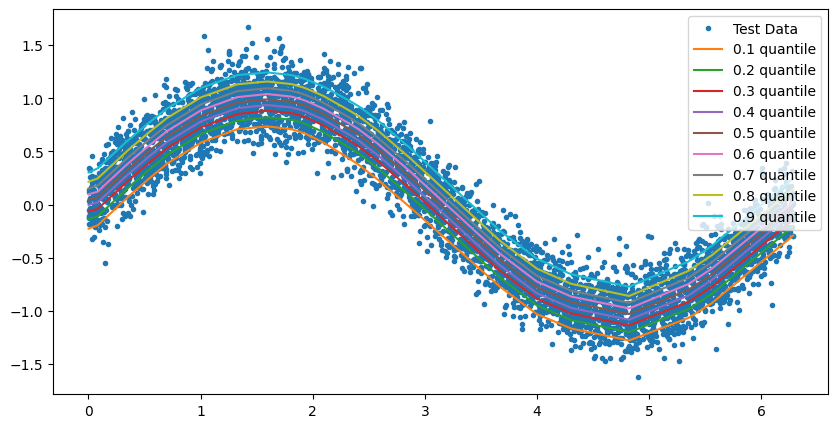

In [11]:
sort_indices=np.argsort(X_test[:,0])
X_test_sort=X_test[sort_indices]
y_test_sort=y_test[sort_indices]
preds = model.predict(X_test_sort)

plt.plot(X_test_sort,y_test_sort,'.')
plt.plot(X_test_sort,preds)

legend=["Test Data"]
quantiles_str=[str(quant)+" quantile" for quant in quantiles]
legend.extend(quantiles_str)
plt.legend(legend)
plt.show()

In [12]:
QuantileNetwork.quant_rate(y_test_sort,preds)

array([0.0902, 0.1916, 0.2888, 0.3904, 0.4954, 0.596 , 0.7014, 0.8074,
       0.9054])

In [13]:
def cdf(pred, x, quantiles):
    r"""
    Approximate the posterior CDF for given inputs x.

    Propagates the inputs in x forward through the network and
    approximates the posterior CDF by a piecewise linear function.

    The piecewise linear function is given by its values at approximate
    quantiles :math:`x_\tau`` for :math:`\tau = \{0.0, \tau_1, \ldots,
    \tau_k, 1.0\}` where :math:`\tau_k` are the quantiles to be estimated
    by the network. The values for :math:`x_{0.0}` and :math:`x_{1.0}` are
    computed using

    .. math::

        x_{0.0} = 2.0 x_{\tau_1} - x_{\tau_2}

        x_{1.0} = 2.0 x_{\tau_k} - x_{\tau_{k-1}}

    Arguments:

        x(np.array): Array of shape (n, m) containing n inputs for which
                        to predict the conditional quantiles.

    Returns:

        Tuple (xs, fs) containing the :math:`x`-values in xs and corresponding
        values of the posterior CDF :math:`F(x)` in fs.

    """
    if len(x.shape) > 1:
        s = x.shape[:-1] + (len(quantiles) + 2,)
    else:
        s = (1, len(quantiles) + 2)

    y_pred = np.zeros(s)
    y_pred[:, 1:-1] = pred
    y_pred[:, 0] = 2.0 * y_pred[:, 1] - y_pred[:, 2]
    y_pred[:, -1] = 2.0 * y_pred[:, -2] - y_pred[:, -3]

    qs = np.zeros(len(quantiles) + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs

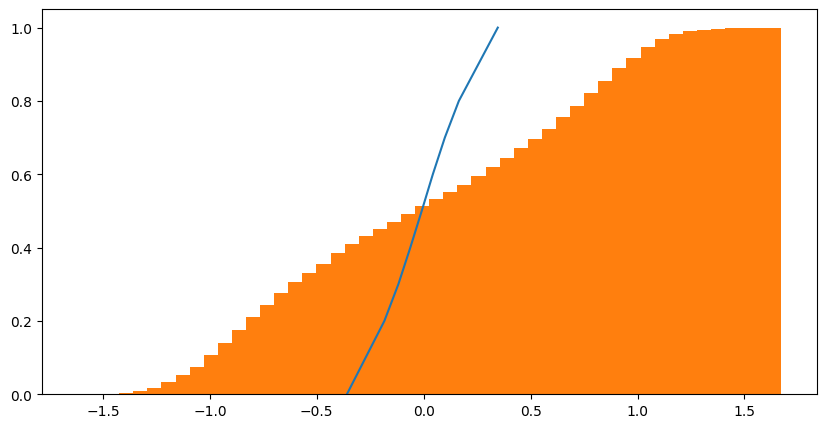

In [14]:
x_cdf, y_cdf = cdf(preds,X_test_sort,quantiles)

plt.plot(np.mean(x_cdf,axis=0),y_cdf)
plt.hist(y_test,cumulative=True, density=True,bins=50)
plt.show()